## **1994 Wage Inequality Among US Citizens Based on Annual Income**

##### Authors: Danielle Keith, Sam Chin, Jason Zheng

### Introduction

**Background:** The 1990s saw a major economic boom in the US. Fueled by a tech boom, the economy grew at 3% with low unemployment and 2 million new jobs. While income increased in 1994, minorities and women still faced significant wage inequality (Wilson, 2016). This highlights that economic prosperity didn't necessarily translate to equal pay for all groups.

**Hypothesis:** An analysis of the 1994 census data will allow us to predict whether a given person's income is greater or lesser than/equal to $50,000 based on factors like level of education, age, sex, race, native country, and hours worked per week.

**Dataset:** We will be using the `Adult` dataset taken from https://archive.ics.uci.edu/dataset/2/adult, which has extracted 32,560 entries from the 1994 US census which is a mandatory survey that collects data from all US citizens. Of the 32,560 rows, each observation represents a single person and their various attributes. There are 15 columns each signifying a different defining factor.

- `age`: age of individual
 - `workclass`: employment status (ex. self-employed, private, unemployed)
 - `fnlwgt`: final weight or the number of people this individual's entry represents
 - `education`: the highest level of education completed (ex. 12th grade, Bachelor's, Doctorate)
 - `education-num`: the highest level of education completed in numerical form 
 - `marital-status`: marital status (ex. married, single)
 - `occupation`: general type of occupation held (ex. sales, services, etc.)
 - `relationship`: primary relationship to others (ex. wife, husband, relative)
 - `race`: racial identity (ex. white, black, asian)
 - `sex`: biological sex (ex. male, female)
 - `capital-gain`: money earned on investments 
 - `capital-loss`: money lost on investments 
 - `hours-per-week`: hours at work each week
 - `native-country`: country of origin (ex. United States, India, Cuba)
 - `income`: annual income in USD (binary, <= 50k, >50k)

### Methods and Results

In [2]:
# Loading libraries
library(tidyverse)
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [3]:
# Reading downloaded csv file
adult <- read_csv("data/adult.csv")

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Data Wrangling

In [10]:
# Adding column names
colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                     'marital_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')

# Many of the predictors are categorical so we need to convert them into numerical values
adult_numerical <- adult |>
    select(race, sex, native_country) |>
    mutate(across(race:native_country, as.factor)) |>
    sapply(unclass) 
adult_final <- adult |>
    select(age, education_num, hours_per_week, income)
adult_final <- cbind(adult_final, adult_numerical) |>
    mutate(income = as_factor(income))

# Getting the training data
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
adult_split <- initial_split(adult_final, prop = 0.75, strata = income)  
adult_train <- training(adult_split)   
adult_test <- testing(adult_split)

#### Data Summary and Visualization

In [13]:
# We will take the mean of our numerical predictors and the mode of our categorical predictors

analysis_mean <- adult_train |>
    select(age, hours_per_week) |>
    map_df(mean, na.rm = TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

analysis_mode <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    map_df(getmode)

# Mean value of our numerical predictors
analysis_mean
# Most frequent value of our categorical predictors 
analysis_mode

age,hours_per_week
<dbl>,<dbl>
38.60363,40.44252


workclass,education,marital_status,occupation,relationship,race,sex,native_country
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


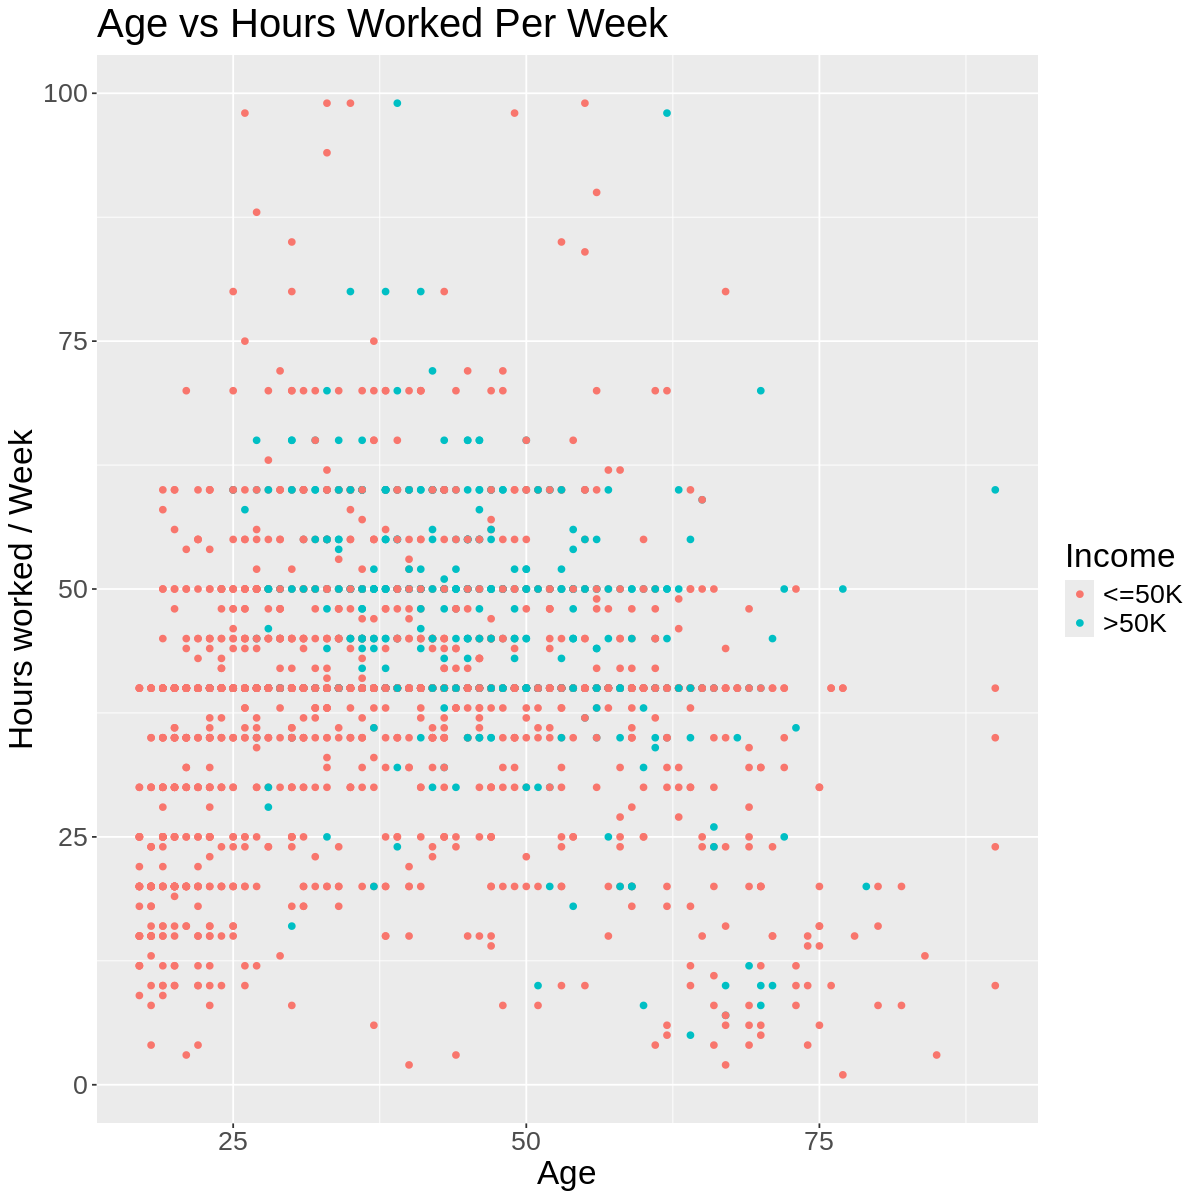

In [6]:
# Data visualization 
# Scatter plot of Age vs Hours Per Week
options(repr.plot.width=10, repr.plot.height=10)

# Currently there is too much data so we want to take a small sample to improve the visualization
filtered_adult <- adult_train |>
    sample_n(2500) 

# Generate plot of Age vs Hours with Coloured Income
age_vs_hrs <- filtered_adult |>
    ggplot(aes(x = age, y = hours_per_week)) +
    geom_point(aes(colour = income)) +
    labs(x = "Age", y = "Hours worked / Week", colour = "Income") +
    ggtitle("Age vs Hours Worked Per Week") +
    theme(text = element_text(size = 20))

age_vs_hrs

#### Data Analysis

In [14]:
income_recipe <- recipe(income ~ ., data = adult_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

#### *Expected Findings*
- More younger people have an annual income greater than 50,000 dollars due to results also showing them having longer years of formal education.
- More non-white, female, immigrants are likely to have an annual income of less than 50,000 compared to white, male, native US residents.
- More non-white, female, immigrants work longer hours than white, male, native US residents despite having a lower income.

#### *Impact of Findings*
The results of the suggested findings can be compared to modern-day statistics to determine if the annual income for different races, sex, age, and native groups has changed. Modern findings may suggest a decrease in wage inequality between race and sex groups, allowing us to identify what changes were made. If modern stats show immigrants making an annual income more comparable to native US residents than in 1994, the government can use it as a way of attracting migrants to the country. If in 2024, data shows younger generations having more years of formal education compared to older generations, the government can advertise a rise in education levels. 

#### *Future Questions*
- Is formal education an important way to increase annual income in 2024 compared to 30 years ago?
- Has the wage gap between different races, sex, and resident groups in the United States changed in the last 30 years?
- Are US immigrants likely to receive financial support comparable to native US residents in 2024?

### References